# Figure 1: Algorithms for 1/f-estimation

In [1]:
import fractions
import warnings
from pathlib import Path

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import scipy.signal as sig
import yaml
from fooof.plts.spectra import plot_spectrum
from fooof.sim.gen import gen_aperiodic

from fooof_modified import FOOOF, plot_annotated_peak_search_MG
from utils import elec_phys_signal, irasa

ModuleNotFoundError: No module named 'fooof'

#### Load params and make directory


In [3]:
yaml_file = open('params.yml')
parsed_yaml_file = yaml.load(yaml_file, Loader=yaml.FullLoader)
globals().update(parsed_yaml_file)

Path(fig_path).mkdir(parents=True, exist_ok=True)

#### Simulate signal

In [4]:
# Signal params
sample_rate = 2400  # Hz
window_seconds = 2  # seconds
welch_params_fooof = dict(fs=sample_rate, nperseg=sample_rate)
welch_params_irasa = dict(fs=sample_rate, nperseg=window_seconds*sample_rate)

# Aperiodic parameters
aperiodic_exponent_simulation = 1

# Periodic parameters
peak_center_freq = 10  # Hz
peak_amplitude = .02
peak_width = .001

periodic_params = [(peak_center_freq, peak_amplitude, peak_width)]

# Simulate Signal
tme_series_params = dict(exponent=aperiodic_exponent_simulation,
                         periodic_params=periodic_params)
aperiodic_signal, full_signal = elec_phys_signal(**tme_series_params)

# Increase arbitrary units
aperiodic_signal, full_signal = aperiodic_signal*1e6, full_signal*1e6

# Calc PSD
freqs_fooof, psd_full_fooof = sig.welch(full_signal, **welch_params_fooof)
freqs_irasa, psd_full_irasa = sig.welch(full_signal, **welch_params_irasa)

# Keep PSD within 3Hz-30Hz for visualization
highpass = 3
lowpass = 30
freq_mask_fooof = (freqs_fooof >= highpass) & (freqs_fooof <= lowpass)
freqs_fooof = freqs_fooof[freq_mask_fooof]
psd_full_fooof = psd_full_fooof[freq_mask_fooof]

freq_mask_irasa = (freqs_irasa >= highpass) & (freqs_irasa <= lowpass)
freqs_irasa = freqs_irasa[freq_mask_irasa]
psd_full_irasa = psd_full_irasa[freq_mask_irasa]


#### Apply fooof to simulated signal


In [5]:
fm = FOOOF(max_n_peaks=1, verbose=False)  # initialize
fm.add_data(freqs_fooof, psd_full_fooof)  # add data

# Fit the power spectrum model
freq_range = (highpass, lowpass)
fm.fit(freqs_fooof, psd_full_fooof, freq_range)

#### Extract initial fooof fit and initial flattened PSD

In [6]:
# Do an initial aperiodic fit -> a robust fit, that excludes outliers
init_ap_fit = gen_aperiodic(fm.freqs,
                            fm._robust_ap_fit(fm.freqs, fm.power_spectrum))

# Recompute the flattened spectrum using the initial aperiodic fit
init_flat_spec = fm.power_spectrum - init_ap_fit
init_flat_spec_lin = 10**fm.power_spectrum - 10**init_ap_fit

#### Apply IRASA to simulated signal
IRASA code modified from https://raphaelvallat.com/yasa/build/html/index.html

In [7]:
# Set resampling factors
hset = np.array([1.3, 1.6, 2])
hset_inv = 1 / hset

# Set parameters and apply
irasa_params = dict(sf=sample_rate, band=freq_range,
                    win_sec=window_seconds, hset=hset)
IRASA = irasa(data=full_signal, **irasa_params)
freqs_irasa_full, psd_ap, psd_osc, params = IRASA

psd_ap, psd_osc = psd_ap[0], psd_osc[0]  # only one spectrum fitted

#### Save IRASA's intermediate resampling steps for visualization

In [8]:
# Initialize arrays
window_samples = welch_params_irasa["nperseg"]
psds_resampled = np.zeros((len(hset), *psd_full_irasa.shape))
psds_up = np.zeros((len(hset), *psd_full_irasa.shape))
psds_dw = np.zeros((len(hset), *psd_full_irasa.shape))

for i, h in enumerate(hset):
    
    # Get the upsampling/downsampling (h, 1/h) factors as integer
    rat = fractions.Fraction(str(h))
    up, down = rat.numerator, rat.denominator
    
    # resample
    data_up = sig.resample_poly(full_signal, up, down)
    data_down = sig.resample_poly(full_signal, down, up, axis=-1)
    
    # calc PSD
    freqs_up, psd_up = sig.welch(data_up, h * sample_rate,
                                 nperseg=window_samples)
    freqs_dw, psd_dw = sig.welch(data_down, sample_rate / h,
                                 nperseg=window_samples)
    # save
    psds_up[i, :] = psd_up[freq_mask_irasa]
    psds_dw[i, :] = psd_dw[freq_mask_irasa]

    # Geometric mean:
    psds_resampled[i, :] = np.sqrt(psd_up * psd_dw)[freq_mask_irasa]

# Now we take the median PSD of all the resampling factors, which gives
# a good estimate of the aperiodic component of the PSD.
psd_median = np.median(psds_resampled, axis=0)

#### Plot functions for each subplot

In [9]:
def input_series(ax, duration=1, step=sample_rate//100):
    """Create dummy time series signal."""
    time = np.arange(0, len(full_signal)/sample_rate, 1/sample_rate)
    time_series = np.sin(2 * np.pi * peak_center_freq * time)
    time_series += .01 * aperiodic_signal  # add some 1/f
    mask = [(time >= duration) & (time <= 2*duration)]

    ax.plot(time[mask][::step],
            time_series[mask][::step],
            c_sim, lw=1, label="Signal")
    ax.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    ax.axis("off")


def input_psd(ax):
    """Plot input PSD."""
    ax.loglog(freqs_fooof, psd_full_fooof, c_sim, lw=1, label="PSD")
    ax.set(xticks=[], yticks=[], xticklabels=[], yticklabels=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.set_yticklabels([], minor=True)
    ax.set_xticklabels([], minor=True)
    ax.axis("off")


def fooof_1(ax, ybottom=1):
    """Plot initial fooof fit."""
    plot_spectrum(fm.freqs, 10**fm.power_spectrum, log_freqs=False,
                  lw=1.5, color=c_sim, ax=ax)
    plot_spectrum(fm.freqs, 10**init_ap_fit, log_freqs=False,
                  label='Initial Fit', color=c_fit, lw=2, alpha=1,
                  ls=(0, (3, 3)), ax=ax)
    ax.grid(False)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin / ybottom, ymax))
    ax.axis("off")
    leg = ax.legend(handlelength=2, handletextpad=.5, loc="lower center",
                    frameon=False)
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    for legobj in leg.legendHandles:
        legobj.set_linewidth(1.5)
        legobj.set_linestyle((.6, (3, 2)))


def fooof_2(ax, yscale=1.5, ybottom=1):
    """Plot flattended spectrum."""
    plot_spectrum(fm.freqs, init_flat_spec, log_freqs=False,
                  label='Flattened PSD', lw=1.5, color=c_flat, ax=ax)
    ax.set_xscale("log")
    ax.grid(False)
    ax.axis("off")
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin/ybottom, ymax))
    ymin, ymax = ax.get_ylim()
    ylim = ax.set_ylim([ymin, yscale*ymax])
    ax.get_legend().remove()
    leg = ax.legend(handlelength=1, handletextpad=.5, frameon=False,
                    loc="lower center")
    for legobj in leg.legendHandles:
        legobj.set_linewidth(1.5)
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    return ylim


def fooof_3(ax, ylim=None):
    """Plot fooof Gauss fits."""
    plot_annotated_peak_search_MG(fm, 0, ax, lw=1.5,
                                  markersize=10,
                                  c_flat=c_flat, c_gauss=c_osc,
                                  c_thresh=c_thresh, label_flat=None,
                                  label_rthresh=None,
                                  anno_rthresh_font=legend_fontsize_small)
    ax.set_xscale("log")
    ax.grid(False)
    ax.axis("off")
    if ylim:
        ax.set_ylim(ylim)
    leg = ax.legend(handlelength=1.5, frameon=False, loc=(.17, 0),
                    handletextpad=.2)
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    for legobj in leg.legendHandles:
        legobj.set_linewidth(2)
        legobj.set_linestyle((0, (1, 1)))
    ax.set_title(None)


def fooof_4(ax, ylim=None, ybottom=1):
    """Plot fooof Gauss fit removal."""
    plot_annotated_peak_search_MG(fm, 1, ax,
                                  lw=1.5, markersize=10,
                                  c_flat=c_flat, c_gauss=c_osc,
                                  c_thresh=c_thresh, anno_rthresh_font=None)
    ax.set_xscale("log")
    ax.grid(False)
    ax.axis("off")
    if ylim:
        ax.set_ylim(ylim)
    ax.set_title(None)


def aperiodic_fit(ax, ybottom=1):
    """Plot final aperiodic fit."""
    plot_spectrum(fm.freqs, 10**fm._spectrum_peak_rm, log_freqs=False,
                  label='Aperiodic PSD', color=c_aperiodic, lw=3, ax=ax)
    plot_spectrum(fm.freqs, 10**fm._ap_fit, log_freqs=False,
                  label='Aperiodic Fit', lw=2,
                  color=c_fit, alpha=1, ls=(0, (3, 3)), ax=ax)
    ax.set_yscale("log")
    ax.set_xscale("log")
    ax.grid(False)
    ymin, ymax = ax.get_ylim()
    ax.set_ylim((ymin/ybottom, ymax))
    leg = ax.legend(handlelength=2, handletextpad=.5, frameon=False,
                    loc="lower center")
    leg.legendHandles[0].set_linewidth(1.5)
    leg.legendHandles[1].set_linewidth(1.5)
    leg.legendHandles[1].set_linestyle((0, (2.5, 2)))
    leg.get_frame().set_alpha(None)
    leg.get_frame().set_facecolor((0, 0, 1, 0))
    ax.axis("off")


def IRASA_res1(ax, ybottom=None, ytop=None):
    """Plot IRASA resampling h1."""
    ax.loglog(freqs_irasa, psds_up[0], c_h1, lw=1)
    ax.loglog(freqs_irasa, psd_full_irasa, c_sim, lw=1, ls="--",
              label=rf"$h={hset[0]:.1f}$")
    ax.loglog(freqs_irasa, psds_dw[0], c_h1, lw=1,
              label=rf"$h=\frac{{{1}}}{{{hset[0]:.1f}}}$")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ax.set_ylabel("Resampled\nPSD pairs", labelpad=-12, y=.4,
                  fontsize=legend_fontsize_small)
    ax.set_title(f"h={hset[0]:.1f}",
                 y=.65, fontsize=legend_fontsize_small)
    ymin, ymax = ax.get_ylim()
    if ybottom and not ytop:
        ax.set_ylim((ymin/ybottom, ymax))
    if ytop and not ybottom:
        ax.set_ylim((ymin, ymax/ytop))
    if ytop and ybottom:
        ax.set_ylim((ymin/ybottom, ymax/ytop))


def IRASA_res2(ax, ybottom=None, ytop=None):
    """Plot IRASA resampling h2."""
    ax.loglog(freqs_irasa, psd_full_irasa, c_sim, lw=1, ls="--")
    ax.loglog(freqs_irasa, psds_up[1], c_h2, lw=1,
              label=rf"$h={hset[1]:.1f}$")
    ax.loglog(freqs_irasa, psds_dw[1], c_h2, lw=1,
              label=rf"$h=\frac{{{1}}}{{{hset[1]:.1f}}}$")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ax.set_title(f"h={hset[1]:.1f}",
                 y=.65, fontsize=legend_fontsize_small)
    ymin, ymax = ax.get_ylim()
    if ybottom and not ytop:
        ax.set_ylim((ymin/ybottom, ymax))
    if ytop and not ybottom:
        ax.set_ylim((ymin, ymax/ytop))
    if ytop and ybottom:
        ax.set_ylim((ymin/ybottom, ymax/ytop))


def IRASA_res3(ax, ybottom=None, ytop=None):
    """Plot IRASA resampling h3."""
    ax.loglog(freqs_irasa, psds_up[2], c_h3, lw=1,
              label=rf"$h={hset[2]:.0f}$")
    ax.loglog(freqs_irasa, psd_full_irasa, c_sim, lw=1, ls="--")
    ax.loglog(freqs_irasa, psds_dw[2], c_h3, lw=1,
              label=rf"$h=\frac{{{1}}}{{{hset[2]:.0f}}}$")
    ax.set_title(f"h={hset[2]:.0f}",
                 y=.65, fontsize=legend_fontsize_small)
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_visible(False)
    ax.spines["bottom"].set_visible(False)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ymin, ymax = ax.get_ylim()
    if ybottom and not ytop:
        ax.set_ylim((ymin/ybottom, ymax))
    if ytop and not ybottom:
        ax.set_ylim((ymin, ymax/ytop))
    if ytop and ybottom:
        ax.set_ylim((ymin/ybottom, ymax/ytop))


def IRASA_mean1(ax, ybottom=None, lw_median=.1):
    """Plot IRASA geometric mean h1."""
    ax.loglog(freqs_irasa, psd_full_irasa, c_sim, lw=1, ls="--")
    ax.loglog(freqs_irasa, psds_resampled[0], c_h1, lw=1,
              label=f"h={hset[i]}")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_linewidth(lw_median)
    ax.spines["top"].set_linewidth(lw_median)
    ax.spines["bottom"].set_linewidth(lw_median)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ax.set_ylabel("Geometric\nmean", labelpad=-12, y=.5,
                  fontsize=legend_fontsize_small)
    if ybottom:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim((ymin/ybottom, ymax))


def IRASA_mean2(ax, ybottom=None, lw_median=.1):
    """Plot IRASA geometric mean h2."""
    ax.loglog(freqs_irasa, psd_full_irasa, c_sim, lw=1, ls="--")
    ax.loglog(freqs_irasa, psds_resampled[1], c_h2, lw=1,
              label=f"h={hset[i]}")
    ax.spines["right"].set_visible(False)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_linewidth(lw_median)
    ax.spines["bottom"].set_linewidth(lw_median)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    if ybottom:
        ymin, ymax = ax.get_ylim()
        ax.set_ylim((ymin/ybottom, ymax))


def IRASA_mean3(ax, ybottom=None, lw_median=.1):
    """Plot IRASA geometric mean h3."""
    ax.loglog(freqs_irasa, psd_full_irasa, c_sim, lw=1, ls="--")
    ax.loglog(freqs_irasa, psds_resampled[2],  c_h3, lw=1,
              label=f"h={hset[i]}")
    ax.spines["right"].set_linewidth(lw_median)
    ax.spines["left"].set_visible(False)
    ax.spines["top"].set_linewidth(lw_median)
    ax.spines["bottom"].set_linewidth(lw_median)
    ax.set(xticks=[], yticks=[])
    ax.set_yticks([], minor=True)
    ax.set_xticks([], minor=True)
    ax.patch.set_visible(False)
    ymin, ymax = ax.get_ylim()
    if ybottom:
        ax.set_ylim((ymin/ybottom, ymax))
    freq = 5
    ax.annotate(f"{freq}Hz     ",
                xy=(freq, psd_full_irasa[freqs_irasa == freq][0]),
                xytext=(freq, ymin*.9), fontsize=legend_fontsize_small, ha="center",
                arrowprops=dict(arrowstyle="-", lw=1, ls=":", shrinkA=0))
    freq = 10
    ax.annotate(f"{freq}Hz",
                xy=(freq, psd_full_irasa[freqs_irasa == freq][0]),
                xytext=(freq, ymin*.9), fontsize=legend_fontsize_small, ha="center",
                arrowprops=dict(arrowstyle="-", lw=1, ls=":", shrinkA=0))
    freq = 20
    ax.annotate(f"       {freq}Hz",
                xy=(freq, psd_full_irasa[freqs_irasa == freq][0]),
                xytext=(freq, ymin*.9), fontsize=legend_fontsize_small, ha="center",
                arrowprops=dict(arrowstyle="-", lw=1, ls=":", shrinkA=0))


def make_frame(ax, c, title=None, lw_box=0, ls_box="-", **kwargs):
    """Make plotting frames."""
    ax = fig.add_subplot(ax, **kwargs)
    ax.tick_params(axis='both', which='both', bottom=0, left=0,
                   labelbottom=0, labelleft=0)
    ax.set_facecolor(c)
    ax.patch.set_alpha(.6)
    ax.spines["right"].set_linestyle(ls_box)
    ax.spines["left"].set_linestyle(ls_box)
    ax.spines["top"].set_linestyle(ls_box)
    ax.spines["bottom"].set_linestyle(ls_box)
    ax.spines["right"].set_linewidth(lw_box)
    ax.spines["left"].set_linewidth(lw_box)
    ax.spines["top"].set_linewidth(lw_box)
    ax.spines["bottom"].set_linewidth(lw_box)
    if title:
        ax.set_title(title)
    return ax

#### Plot settings


In [10]:
# Mpl settings
panel_fontsize_small = 7
legend_fontsize_small = 5
mpl.rcParams['font.size'] = panel_fontsize_small
mpl.rcParams['legend.fontsize'] = legend_fontsize_small
mpl.rcParams["axes.spines.right"] = True
mpl.rcParams["axes.spines.top"] = True
mpl.rcParams["axes.spines.left"] = True
mpl.rcParams["axes.spines.bottom"] = True

# Arrows
arr_props = dict(facecolor='k', width=.3, headwidth=2, headlength=2, shrink=0)
arr_props_round1 = dict(facecolor='k', width=.00001, headwidth=2, headlength=2,
                        shrink=0, connectionstyle="arc3,rad=-.3")

arr_props_round2 = dict(facecolor='k', width=.00001, headwidth=1.7,
                        headlength=1.7, shrink=0,
                        connectionstyle="arc3,rad=-.3",
                        lw=.1, ls=(0, (10, 10)))

warnings.filterwarnings("ignore")

# Figure 1

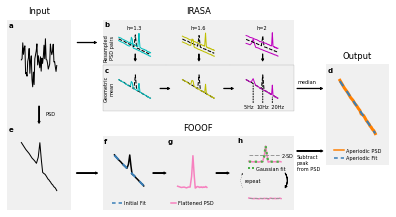

In [11]:
fig = plt.figure(figsize=(fig_width, 3.5))

gs = fig.add_gridspec(nrows=2, ncols=3,
                      width_ratios=[1, 3, 1], height_ratios=[5, 4],
                      wspace=.3, hspace=.3)

# Input gridspec
gs_input = gs[:, 0].subgridspec(2, 1)
input_frame = make_frame(gs_input[:], c_box, title="Input")
inp_margins = dict(xmargin=.4, ymargin=.4)
ax_inp_ser = fig.add_subplot(gs_input[0], **inp_margins)
ax_inp_PSD = fig.add_subplot(gs_input[1], **inp_margins)

# IRASA algorithm gridspec
irasa_frame = make_frame(gs[0, 1], c_box, title="IRASA")
gs_IRASA = gs[0, 1].subgridspec(2, 3, hspace=0, wspace=0)
IR_margins = dict(xmargin=.5, ymargin=.4)
gs_IR11 = fig.add_subplot(gs_IRASA[0, 0], **IR_margins)
gs_IR12 = fig.add_subplot(gs_IRASA[1, 0], **IR_margins)
gs_IR21 = fig.add_subplot(gs_IRASA[0, 1], **IR_margins)
gs_IR22 = fig.add_subplot(gs_IRASA[1, 1], **IR_margins)
gs_IR31 = fig.add_subplot(gs_IRASA[0, 2], **IR_margins)
gs_IR32 = fig.add_subplot(gs_IRASA[1, 2], **IR_margins)

# fooof gridspecs
gs_fooof = gs[1, 1].subgridspec(1, 2, width_ratios=[2, 1])
fooof_frame = make_frame(gs_fooof[:, :], c_box, title="FOOOF")

gs_fooof1 = gs_fooof[0].subgridspec(1, 2, hspace=0)
fooof_margins = dict(xmargin=.4, ymargin=.6)
ax_fooof1 = fig.add_subplot(gs_fooof1[0], **fooof_margins)
ax_fooof2 = fig.add_subplot(gs_fooof1[1], **fooof_margins)

gs_fooof2 = gs_fooof[1].subgridspec(2, 1, hspace=0)
fooof_margins = dict(xmargin=.4)
ax_fooof3 = fig.add_subplot(gs_fooof2[0], **fooof_margins)
ax_fooof4 = fig.add_subplot(gs_fooof2[1], **fooof_margins)

# Output gridspec
gs_output = gs[:, 2].subgridspec(3, 1, height_ratios=[1, 3, 1])
output_frame = make_frame(gs_output[1], c_box, title="Output")
our_margins = dict(xmargin=.4, ymargin=.3)
ap = fig.add_subplot(gs_output[1], **our_margins)

# Add Plots
input_series(ax_inp_ser, duration=.5, step=24)
input_psd(ax_inp_PSD)

IRASA_res1(gs_IR11, ytop=.5)
IRASA_res2(gs_IR21, ytop=.5)
IRASA_res3(gs_IR31, ytop=.5)
IRASA_mean1(gs_IR12, ybottom=1.6)
IRASA_mean2(gs_IR22, ybottom=1.6)
IRASA_mean3(gs_IR32, ybottom=1.6)

fooof_1(ax_fooof1, ybottom=1.5)
ylim = fooof_2(ax_fooof2, yscale=1.0, ybottom=.9)
fooof_3(ax_fooof3, ylim)
fooof_4(ax_fooof4, ylim)

aperiodic_fit(ap, ybottom=2)

# Panel labels
panel_dic = dict(fontweight="bold", fontsize=panel_fontsize_small,
                 x=.03, y=.97, va="top")
ax_inp_ser.text(s="a", transform=ax_inp_ser.transAxes, **panel_dic)
gs_IR11.text(s="b", transform=gs_IR11.transAxes, **panel_dic)
gs_IR12.text(s="c", transform=gs_IR12.transAxes, **panel_dic)
ap.text(s="d", transform=ap.transAxes, **panel_dic)
ax_inp_PSD.text(s="e", transform=ax_inp_PSD.transAxes, **panel_dic)
ax_fooof1.text(s="f", transform=ax_fooof1.transAxes, **panel_dic)
ax_fooof2.text(s="g", transform=ax_fooof2.transAxes, **panel_dic)
ax_fooof3.text(s="h", transform=ax_fooof3.transAxes, **panel_dic)

# Add annotations
ax_inp_ser.annotate(text="", xy=(.5, -.2),
                    xytext=(.5, 0),
                    xycoords='axes fraction',
                    annotation_clip=False, arrowprops=arr_props)
ax_inp_ser.text(s="PSD", x=.6, y=-.11, transform=ax_inp_ser.transAxes,
                fontsize=legend_fontsize_small)


ax_fooof1.annotate(text="", xy=(-.1, .5),
                   xytext=(-.5, .5),
                   xycoords='axes fraction',
                   annotation_clip=False,
                   arrowprops=arr_props)
ax_fooof1.annotate(text="", xy=(1.2, .5),
                   xytext=(.95, .5),
                   xycoords='axes fraction',
                   annotation_clip=False,
                   arrowprops=arr_props)
ax_fooof2.annotate(text="", xy=(1.2, .5),
                   xytext=(.95, .5),
                   xycoords='axes fraction',
                   annotation_clip=False, arrowprops=arr_props)
ax_fooof3.annotate(text="", xy=(.85, -.4),
                   xytext=(.85, 0),
                   xycoords='axes fraction',
                   annotation_clip=False, arrowprops=arr_props_round1)
ax_fooof3.text(s="Subtract\npeak\nfrom PSD",
               x=1.05, y=.5,
               transform=ax_fooof3.transAxes,
               fontsize=legend_fontsize_small, va="top")
ax_fooof4.annotate(text="", xy=(.12, 1),
                   xytext=(.12, .6),
                   xycoords='axes fraction',
                   annotation_clip=False, arrowprops=arr_props_round2)
ax_fooof4.text(s="repeat", x=.15, y=.85, transform=ax_fooof4.transAxes,
               fontsize=legend_fontsize_small, va="top")


gs_IR11.annotate(text="", xy=(-.1, .5),
                 xytext=(-.4, .5),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)
gs_IR11.annotate(text="", xy=(.51, .1),
                 xytext=(.51, .25),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)
gs_IR21.annotate(text="", xy=(.51, .1),
                 xytext=(.51, .25),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)
gs_IR31.annotate(text="", xy=(.51, .1),
                 xytext=(.51, .25),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)
gs_IR12.annotate(text="", xy=(1.05, .5),
                 xytext=(.9, .5),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)
gs_IR22.annotate(text="", xy=(1.05, .5),
                 xytext=(.9, .5),
                 xycoords='axes fraction',
                 annotation_clip=False, arrowprops=arr_props)
gs_IR32.annotate(text="", xy=(1.45, .5),
                 xytext=(1.05, .5),
                 xycoords='axes fraction',
                 annotation_clip=False,
                 arrowprops=arr_props)
gs_IR32.text(s="median",
             x=1.05, y=.7,
             va="top",
             fontsize=legend_fontsize_small,
             transform=gs_IR32.transAxes)
ax_fooof3.annotate(text="", xy=(1.5, .6),
                   xytext=(1.05, .6),
                   xycoords='axes fraction',
                   annotation_clip=False,
                   arrowprops=arr_props)

plt.savefig(fig_path + "Fig1.pdf", bbox_inches="tight")
plt.savefig(fig_path + "Fig1.png", dpi=1000, bbox_inches="tight")
plt.show()